In [366]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage import feature, morphology
from skimage.transform import probabilistic_hough_line

from astropy.io import fits

In [350]:
def downsample_image(image, n):
    """Downsample input image  n x n

    Parameters
    ----------
    image : ndarray 
        2D nx x ny CCD image data.
    n : int
        Resampling scale.
        
    Returns
    -------
    result : 
        Resampled image with shape = image.shape//n
    """
    ny, nx = image.shape
    ny = (ny//n) * n
    nx = (nx//n) * n
    result = image[0:ny, 0:nx].reshape(ny//n,n,nx//n,n).mean(axis=-1).mean(axis=-2)
    return result

def plot_mask(maskfile, hdu='MASK', downsample=1):
    hdus = fits.open(maskfile)
    img = hdus[hdu].data
    
    if downsample > 1:
        m = downsample_image(img, downsample)
    else:
        m = np.copy(img)
    
    dpi = 256
    fig = plt.figure(figsize=(m.shape[1]/dpi, m.shape[0]/dpi), dpi=dpi)
    ax = plt.Axes(fig, [0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    vmax = 1.
    if hdu == 'IMAGE':
        vmax = 100.
        
    ax.imshow(m, cmap='gray', vmin=0, vmax=vmax, origin='lower')
    fig.canvas.draw()
    return fig

def dilate_mask(maskfile, hdu='MASK', downsample=1, dilate=10):
    hdus = fits.open(maskfile)
    img = hdus[hdu].data
    
    if downsample > 1:
        m = downsample_image(img, downsample)
    else:
        m = np.copy(img)
        
    m_binary = m > 0
    m_dilate = morphology.binary_dilation(m_binary, np.ones((dilate, dilate)))
        
    dpi = 256
    fig = plt.figure(figsize=(m_dilate.shape[1]/dpi, m_dilate.shape[0]/dpi), dpi=dpi)
    ax = plt.Axes(fig, [0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(m_dilate, cmap='gray', vmin=0, vmax=1, origin='lower')
    fig.canvas.draw()
    return fig

def plot_chunks(img, mask, proc=None, prefix='test', title=None):
    
    if proc is None:
        if img.shape != mask.shape:
            return
    else:
        if img.shape != mask.shape or img.shape != proc.shape:
            return
    
    nrow, ncol = img.shape
    erow = np.linspace(0,nrow,9, dtype=int)
    ecol = np.linspace(0,ncol,9, dtype=int)

    for i, (r0, r1) in enumerate(zip(erow[:-1], erow[1:])):
        for j, (c0, c1) in enumerate(zip(ecol[:-1], ecol[1:])):
            output = '{}_{:02d}_{:02d}.pdf'.format(prefix, i,j)
            subimg = img[r0:r1, c0:c1]
            submask = mask[r0:r1, c0:c1]

            if proc is None:
                fig, axes = plt.subplots(1,2, figsize=(8,4))
            else:
                fig, axes = plt.subplots(1,3, figsize=(12,4))
                subproc = proc[r0:r1, c0:c1]

            ax = axes[0]
            im = ax.imshow(subimg, cmap='gray', origin='lower', interpolation='nearest', vmin=0, vmax=100)
#             cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            ax.set(xticks=[], yticks=[], title='{}: IMAGE'.format(prefix))
            ax.text(0.02,0.02, '{}:{}, {}:{}'.format(r0,r1,c0,c1), color='yellow', fontsize=8,
                    transform=ax.transAxes)
            ax.text(0.02,0.96, '{}, {}'.format(i,j), color='yellow', fontsize=8,
                    transform=ax.transAxes)
            
            ax = axes[1]
            im = ax.imshow(submask, cmap='gray', origin='lower', interpolation='nearest')
            ax.set(xticks=[], yticks=[], title='{}: MASK'.format(prefix))

            if proc is not None:
                ax = axes[2]
                im = ax.imshow(subproc, cmap='gray', origin='lower', interpolation='nearest')
                # cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ptitle = prefix
                if title is not None:
                    ptitle = '{}: {}'.format(prefix, title)
                ax.set(xticks=[], yticks=[], title=ptitle);

            fig.tight_layout()
            fig.savefig(output)
            plt.close()

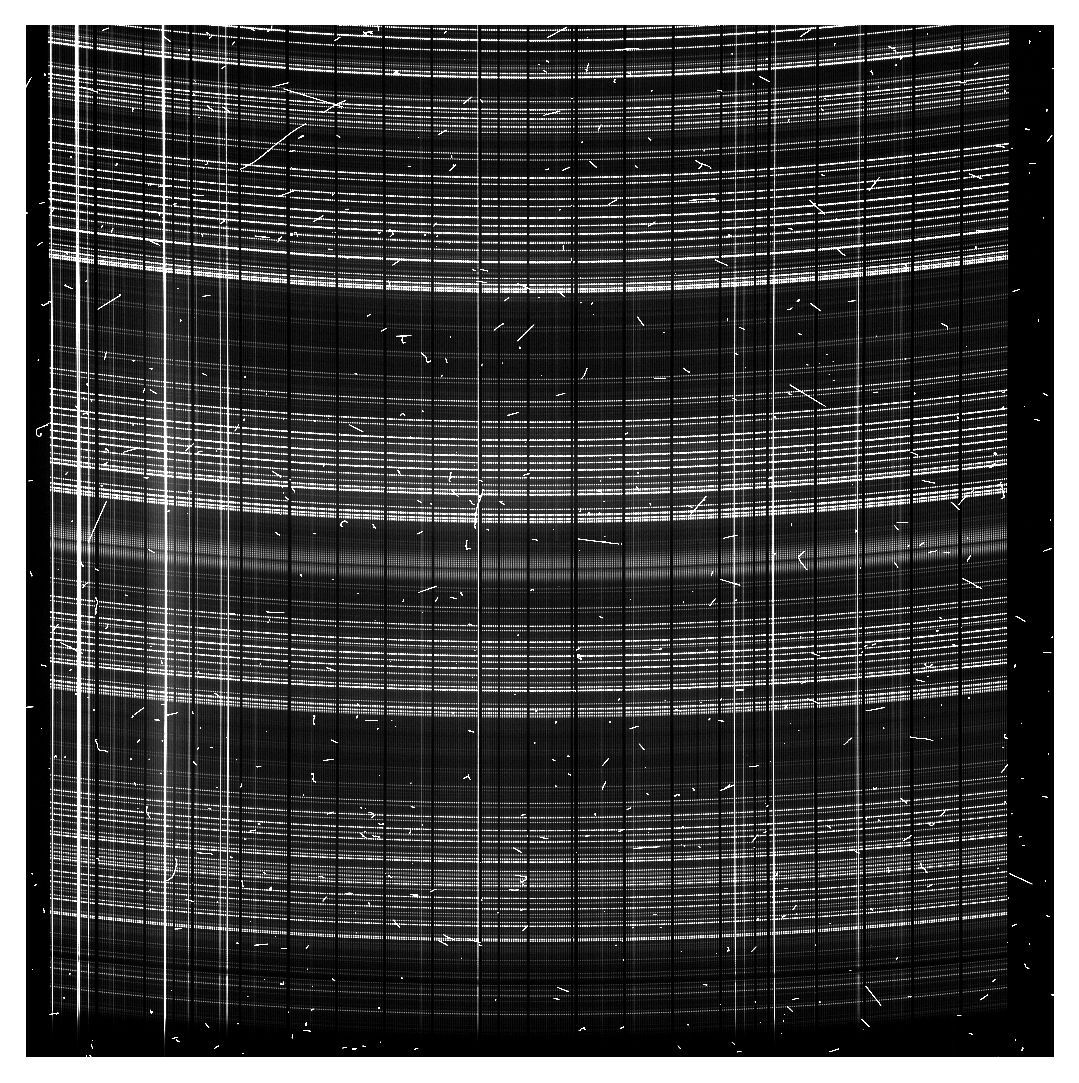

In [364]:
fig = plot_mask('/Users/sybenzvi/Documents/DESI/cmx/preproc-z3-00044518.fits', hdu='IMAGE', downsample=4)
fig.savefig('raw_image.png')

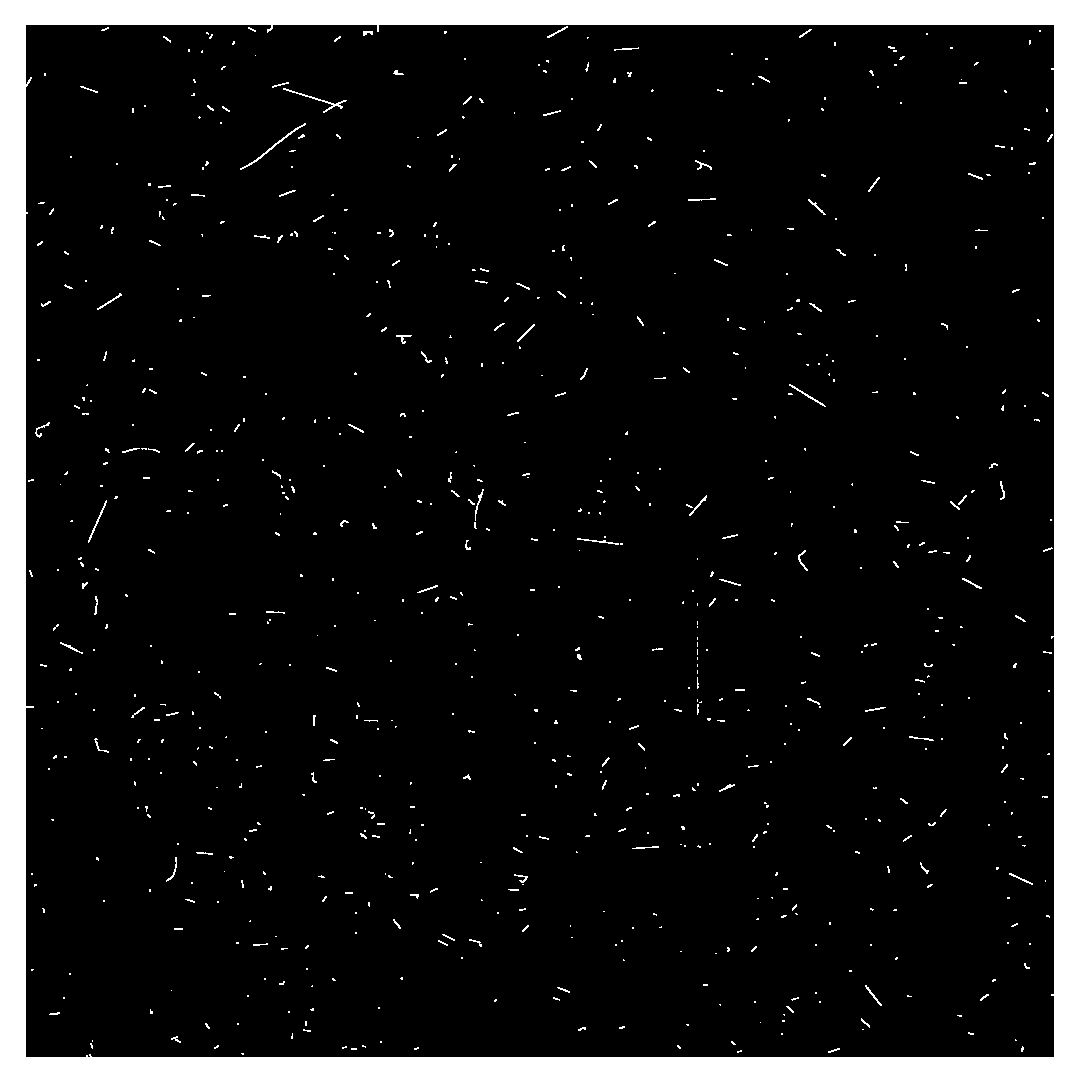

In [365]:
fig = plot_mask('/Users/sybenzvi/Documents/DESI/cmx/preproc-z3-00044518.fits', hdu='MASK', downsample=4)
fig.savefig('msk_image.png')

In [ ]:
fig = dilate_mask('/Users/sybenzvi/Documents/DESI/cmx/preproc-z3-00044518.fits', downsample=1, dilate=3)
fig.savefig('dil_image.pdf')

In [3]:
preprocfile = '/Users/sybenzvi/Documents/DESI/cmx/preproc-z3-00044518.fits'
hdus = fits.open(preprocfile)
mask = hdus['MASK'].data
img = hdus['IMAGE'].data

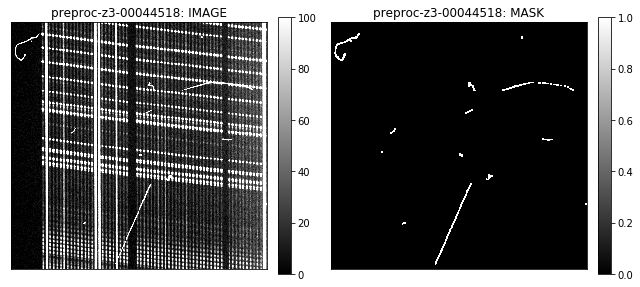

In [117]:
fig, axes = plt.subplots(1,2, figsize=(9,4))

subimg = img[2048:2048+512,32:564]
submask = mask[2048:2048+512,32:564]
submask[submask > 0] = 1
submask[submask < 1] = 0

ax = axes[0]
im = ax.imshow(subimg, cmap='gray', origin='lower', vmin=0, vmax=100)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: IMAGE')

ax = axes[1]
im = ax.imshow(submask, cmap='gray', origin='lower')
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: MASK');

fig.tight_layout()
fig.savefig('compare.pdf')

(4128, 4114)
[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]]


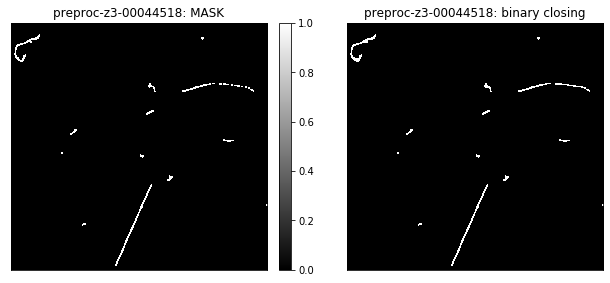

In [216]:
from skimage.morphology import skeletonize, medial_axis, binary_closing, binary_opening, ball
from scipy.ndimage.morphology import generate_binary_structure

fig, axes = plt.subplots(1,2, figsize=(9,4))

ax = axes[0]
im = ax.imshow(submask, cmap='gray', origin='lower')
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: MASK')

print(mask.shape)

neighborhood = np.ones((9,9), dtype=int)
# neighborhood[4:6,:] = 1
# neighborhood[:,5:6] = 1
# for i in range(9):
#     neighborhood[i,i] = 1
#     neighborhood[i,8-i] = 1
print(neighborhood)

ax = axes[1]
bcmask = binary_closing(submask, selem=neighborhood)
im = ax.imshow(bcmask, cmap='gray', origin='lower')
# cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: binary closing');

fig.tight_layout()
fig.savefig('test.pdf')

In [115]:
ball(5)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

(4128, 4114)
(4128, 4114)


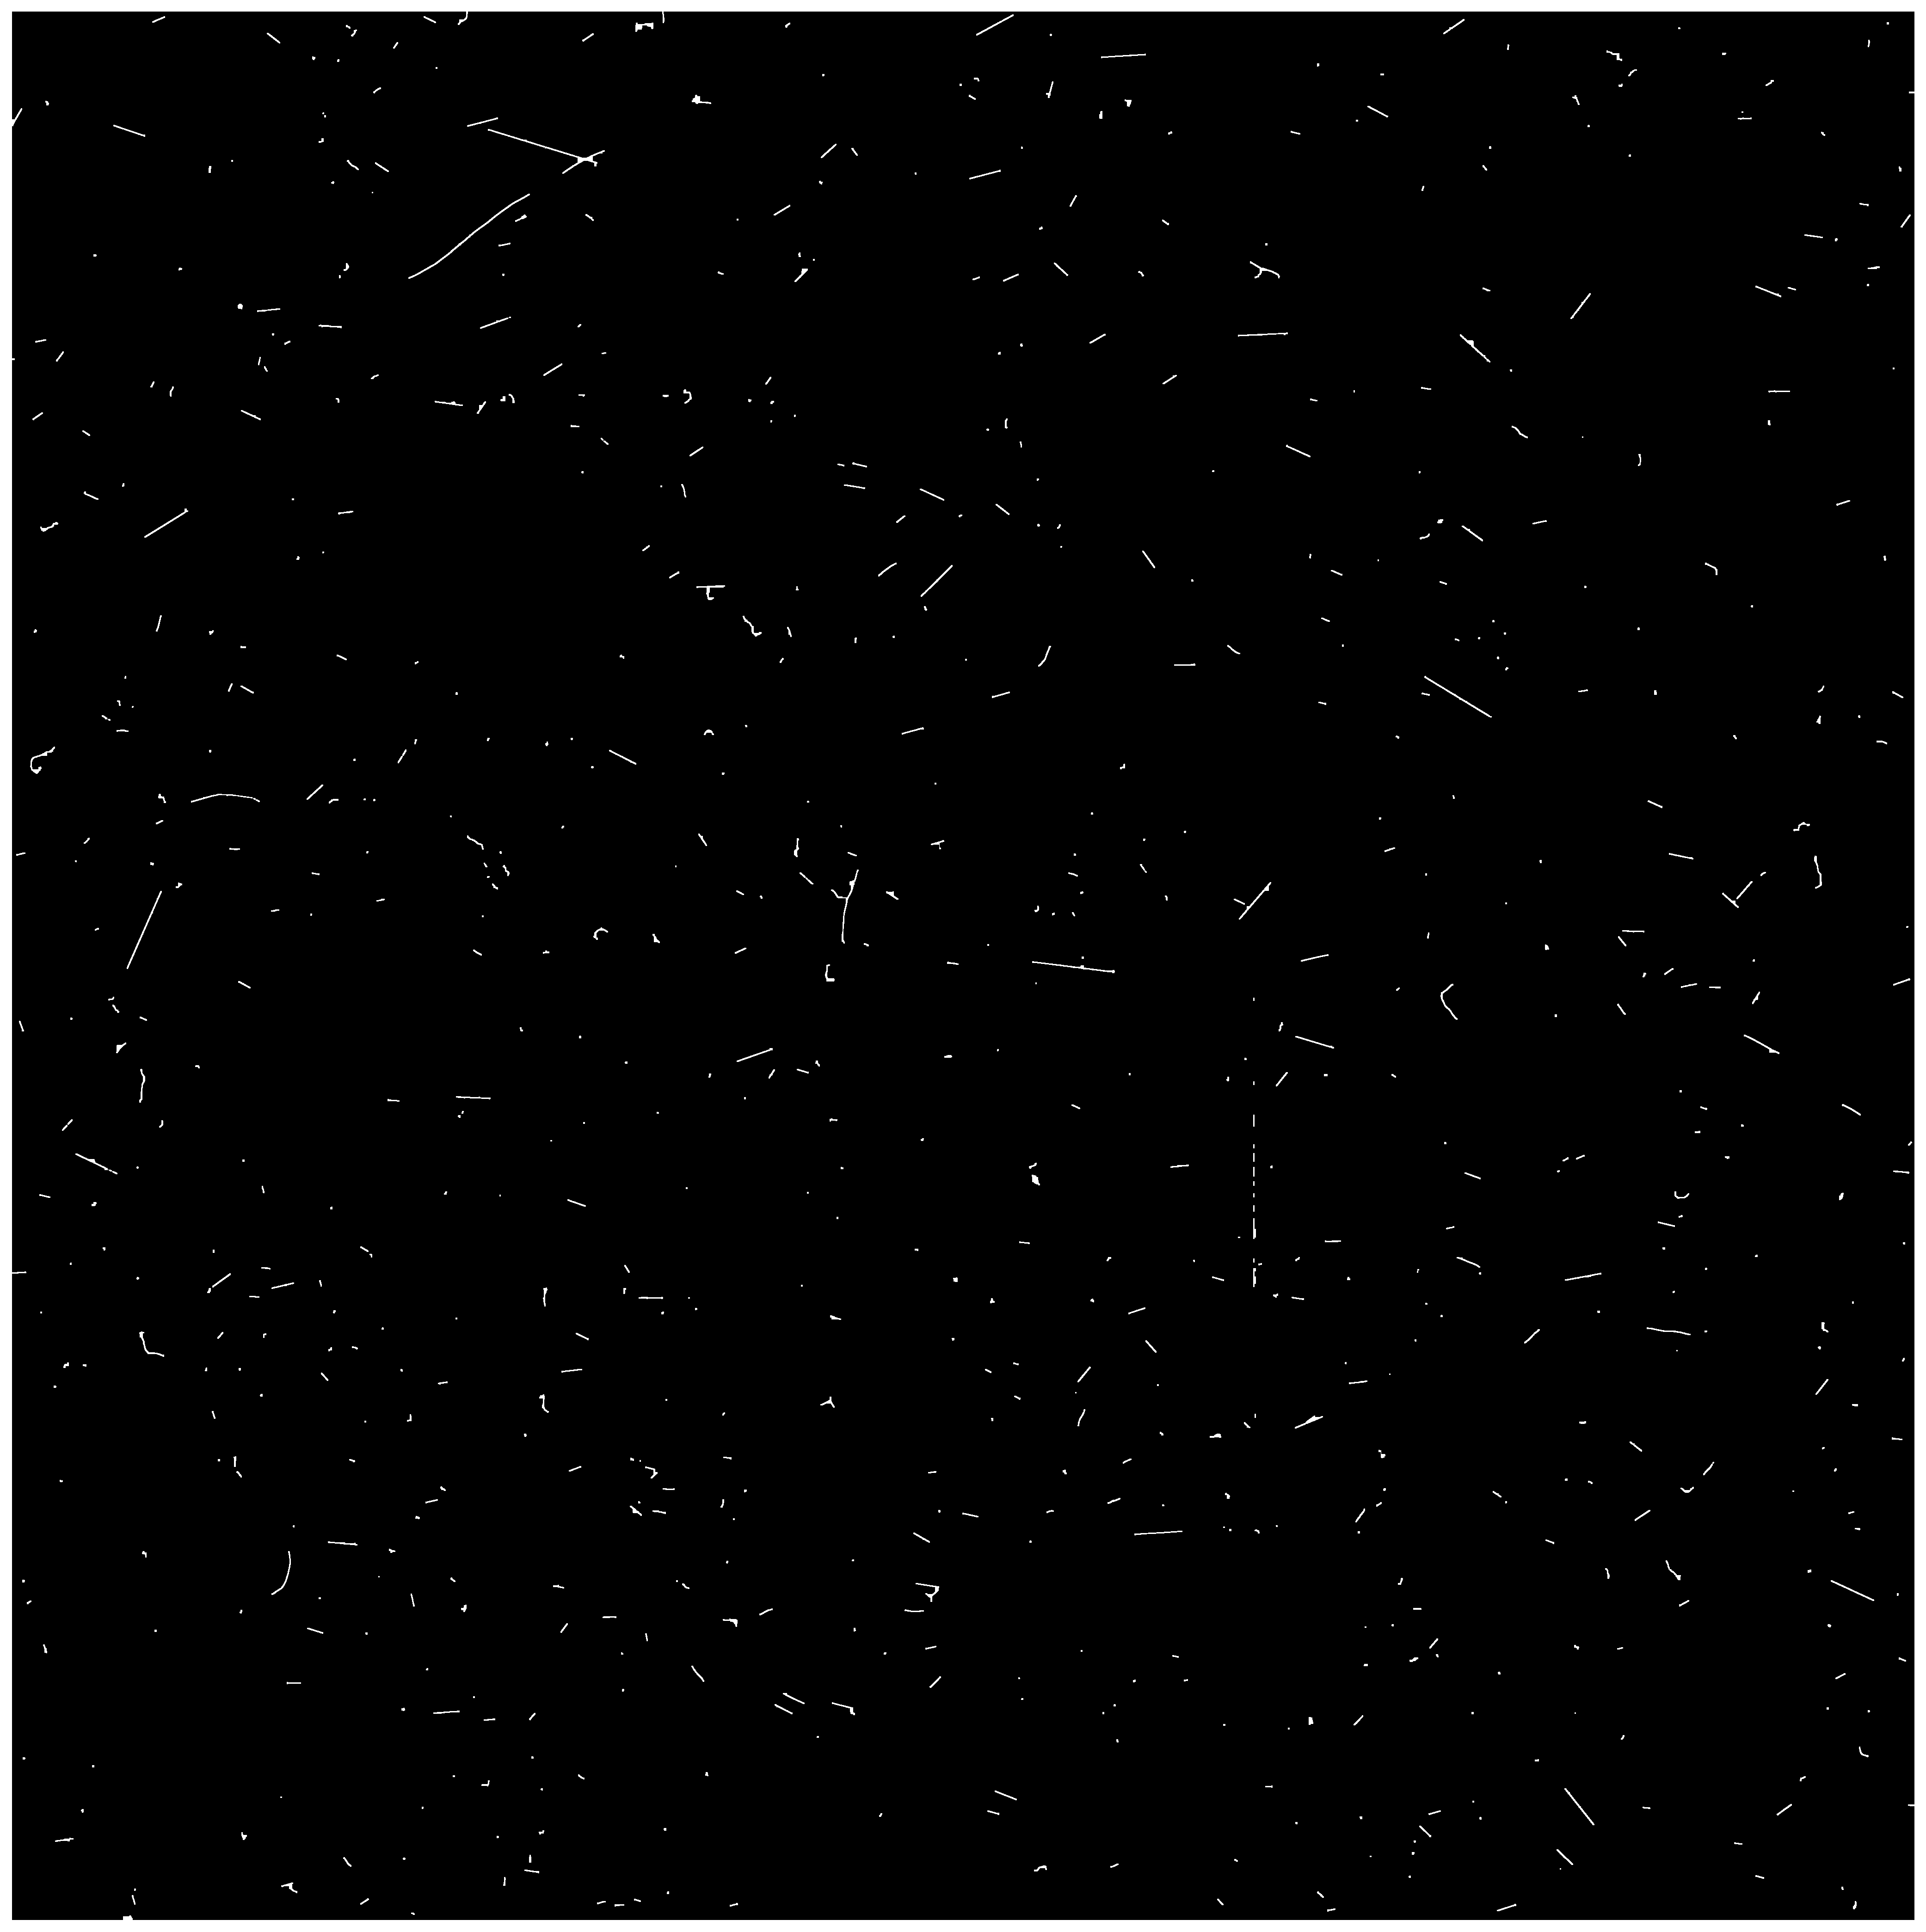

In [108]:
mask[mask > 0] = 1
mask[mask < 1] = 0

print(mask.shape)
bcmask = binary_closing(mask, selem=neighborhood)
print(bcmask.shape)

dpi = 256
fig = plt.figure(figsize=(bcmask.shape[1]/dpi, bcmask.shape[0]/dpi), dpi=dpi)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(bcmask, cmap='gray', vmin=0, vmax=1, origin='lower')
fig.canvas.draw()
fig.savefig('bcmask.pdf')

/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created throu

/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created throu

/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/Users/sybenzvi/anaconda3/envs/desi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


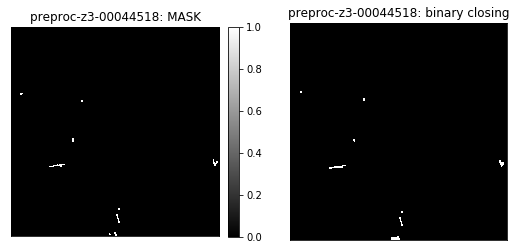

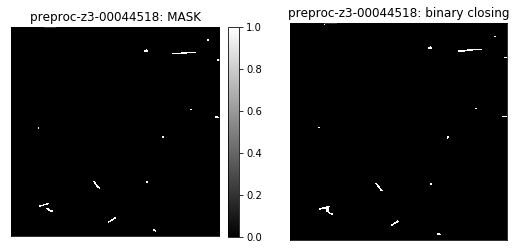

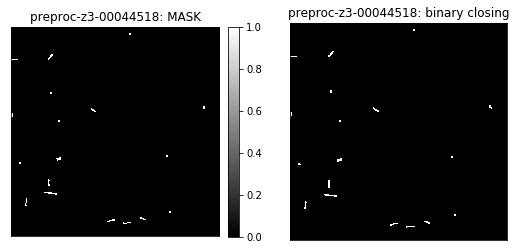

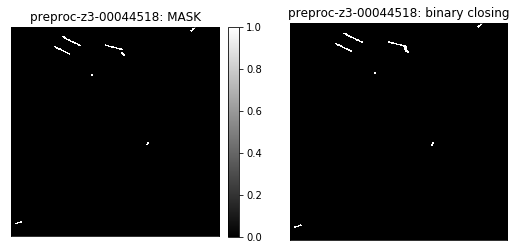

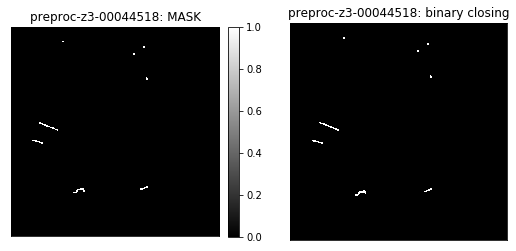

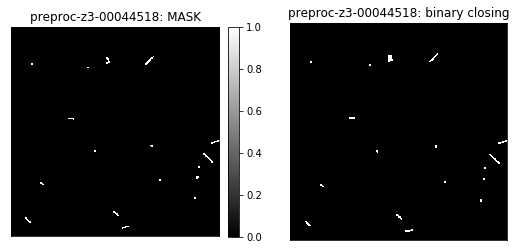

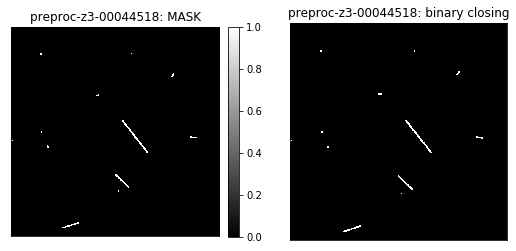

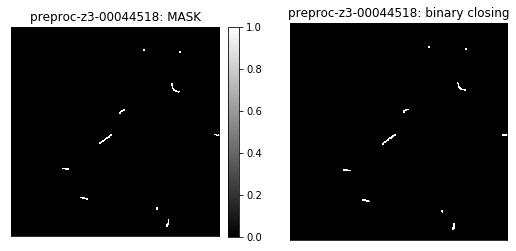

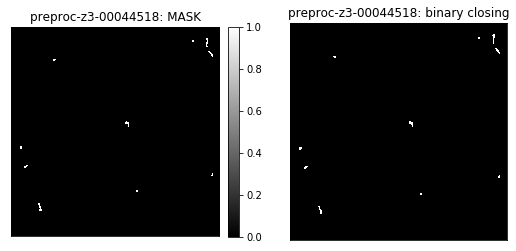

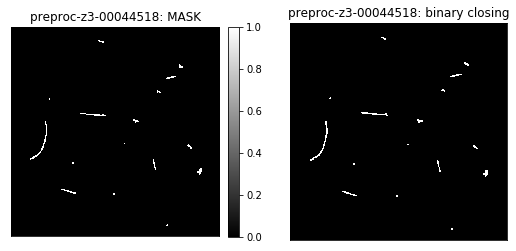

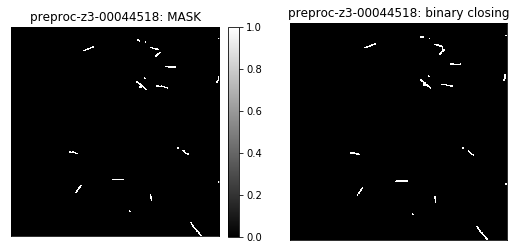

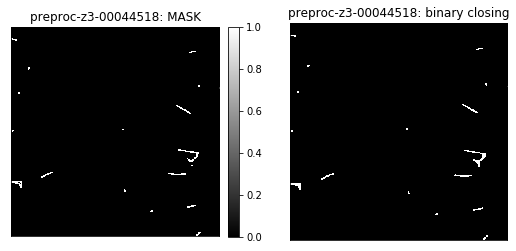

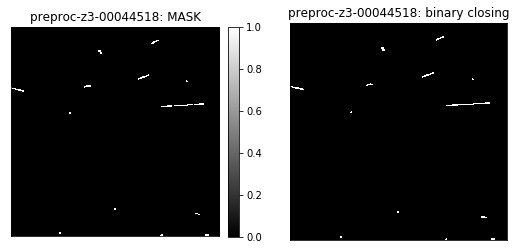

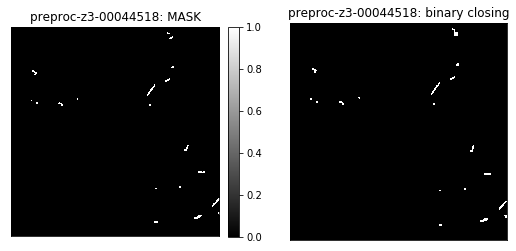

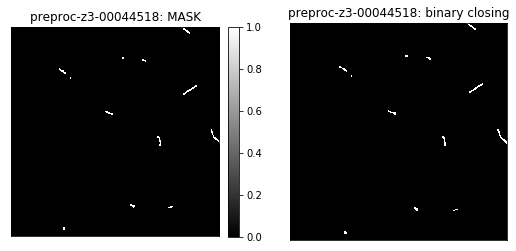

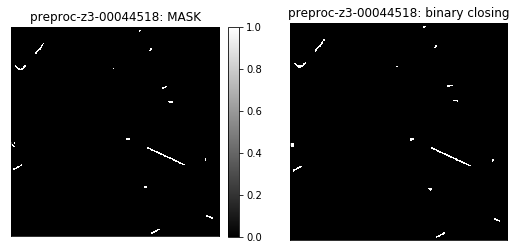

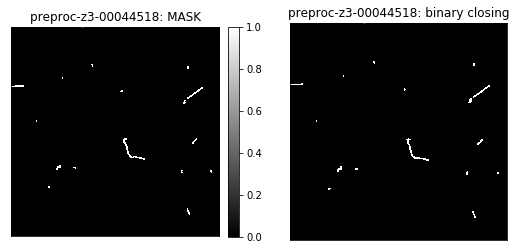

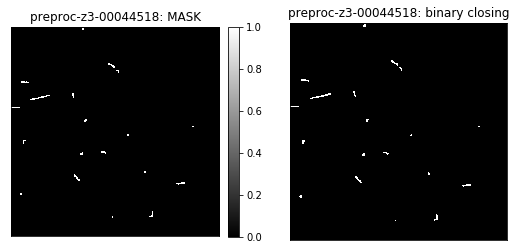

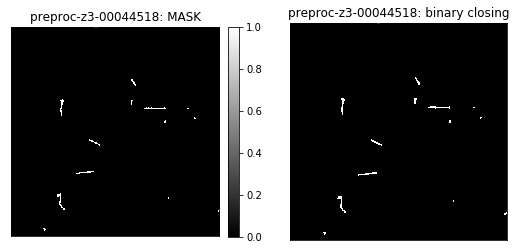

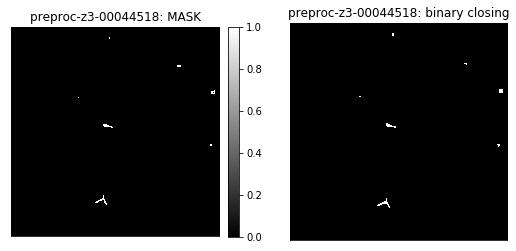

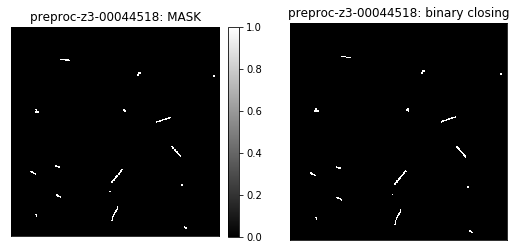

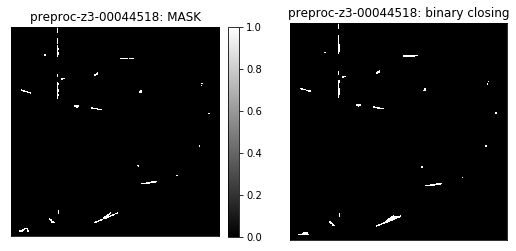

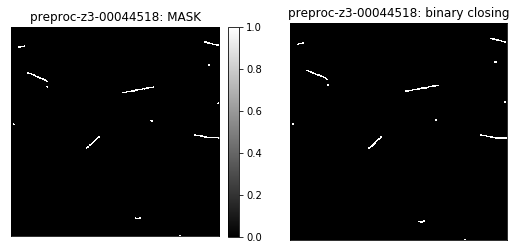

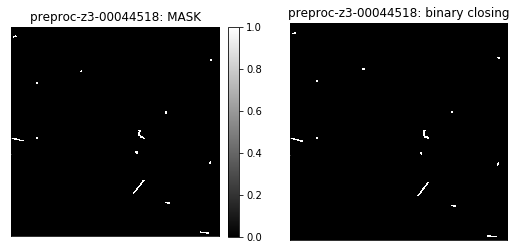

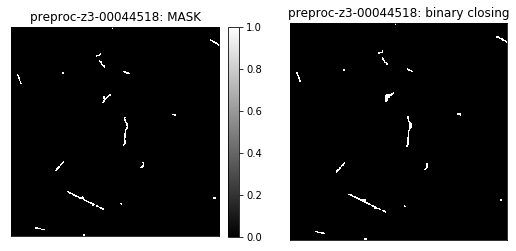

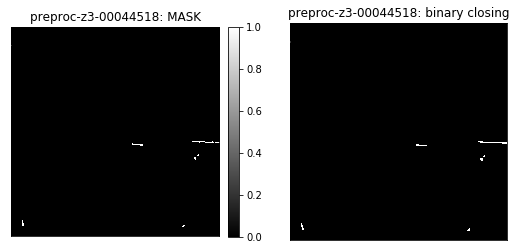

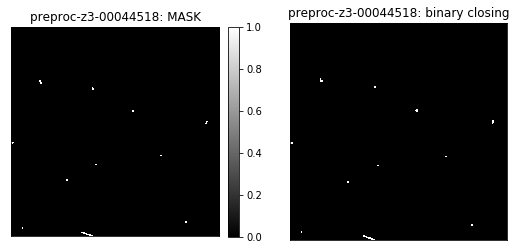

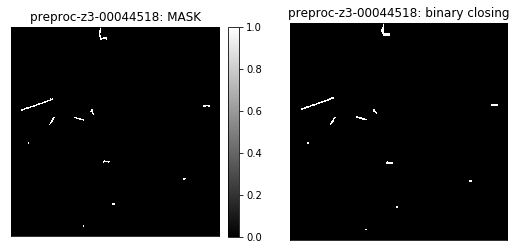

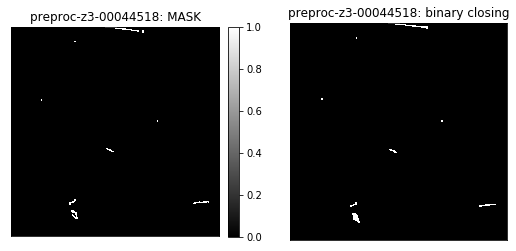

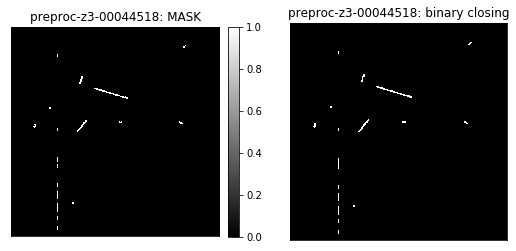

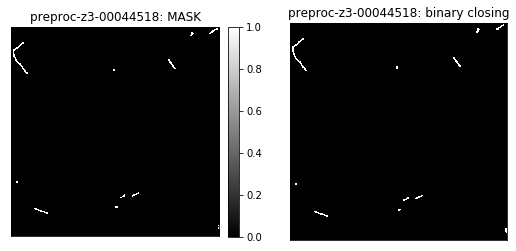

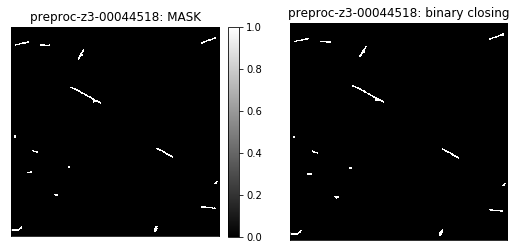

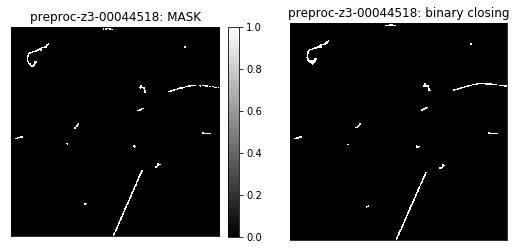

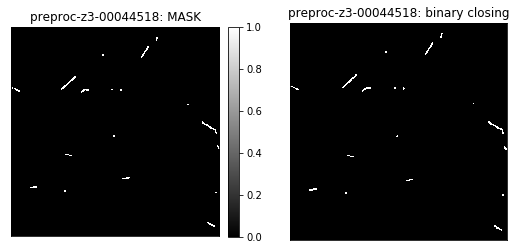

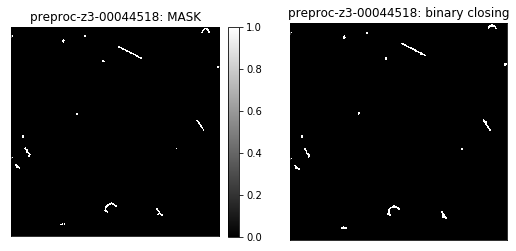

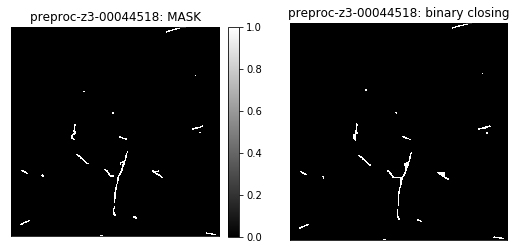

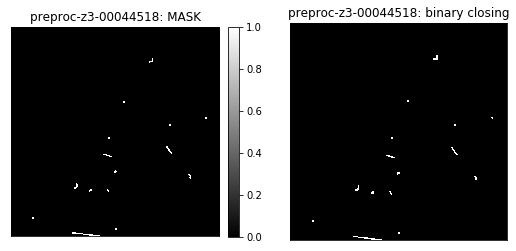

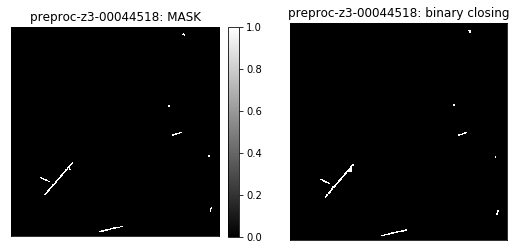

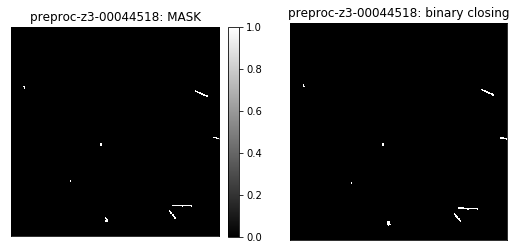

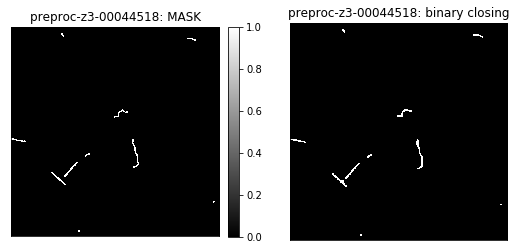

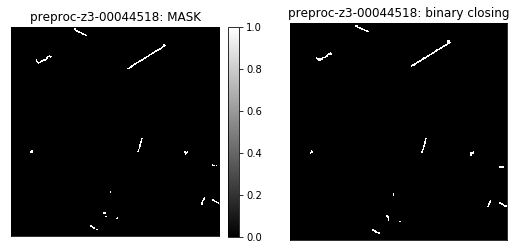

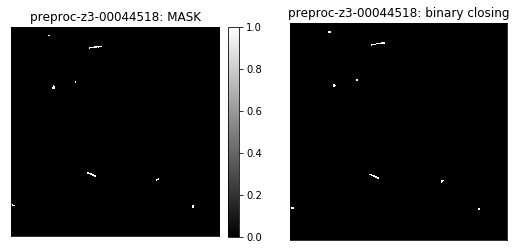

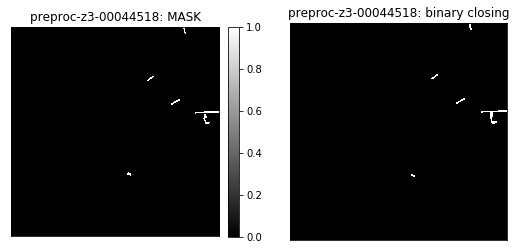

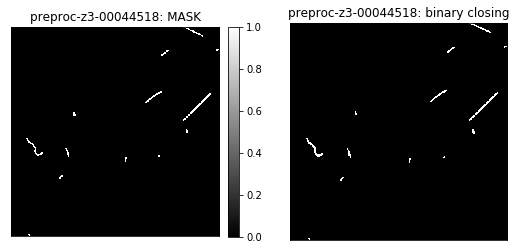

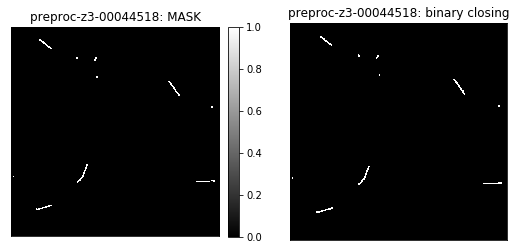

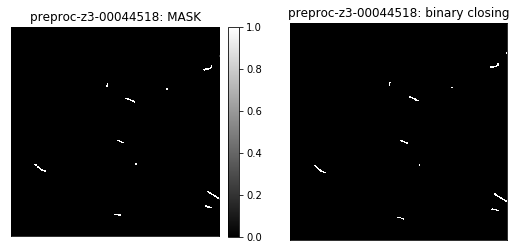

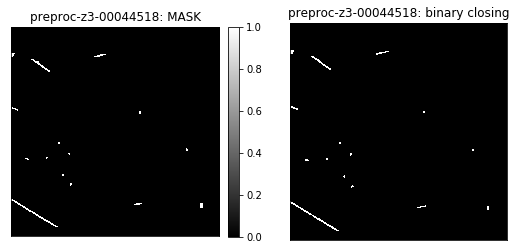

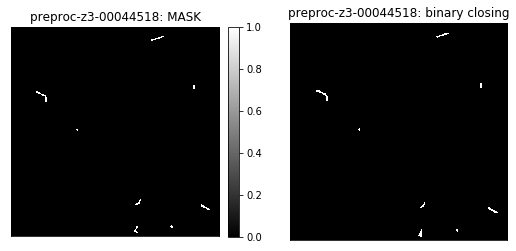

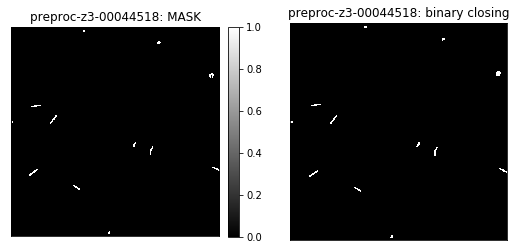

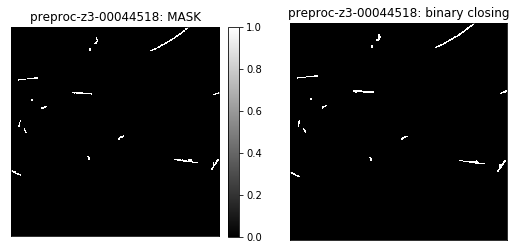

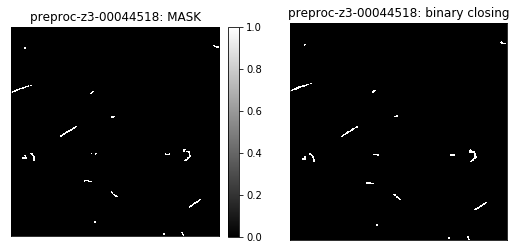

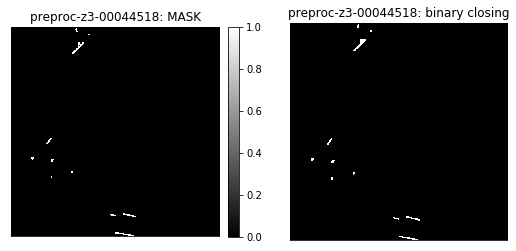

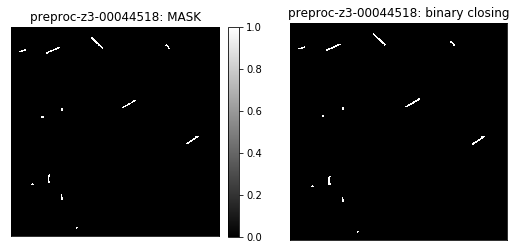

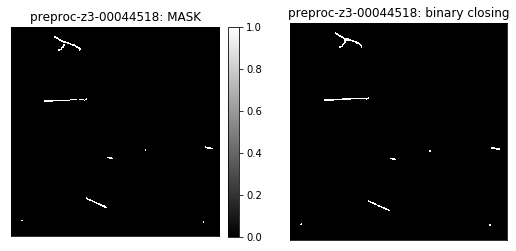

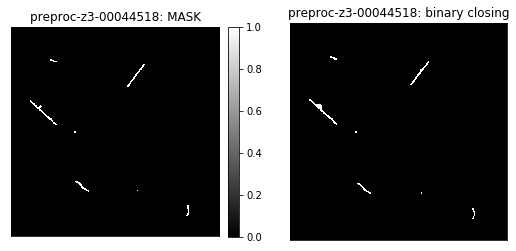

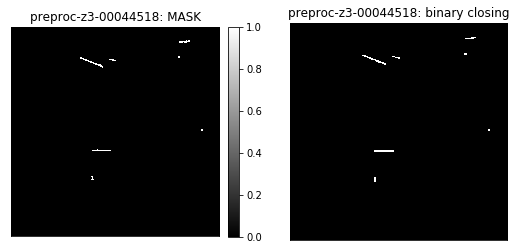

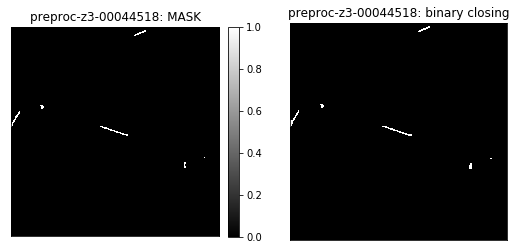

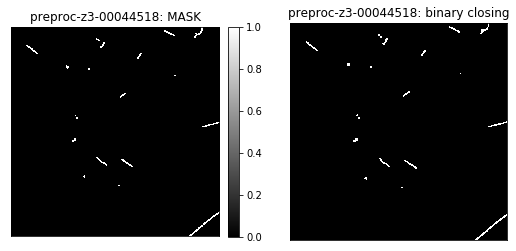

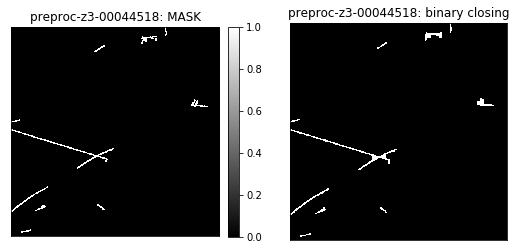

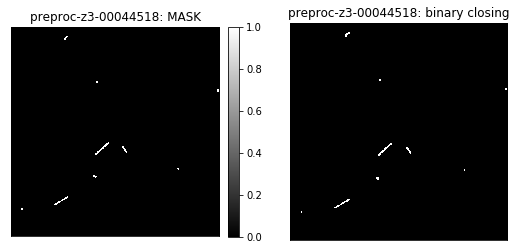

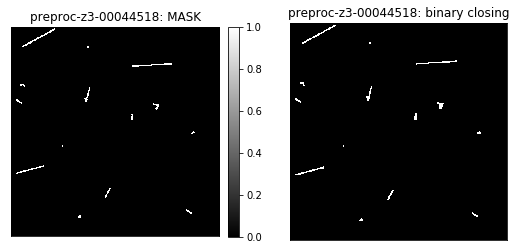

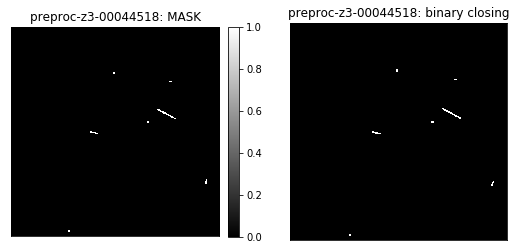

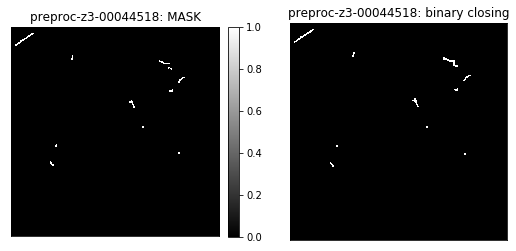

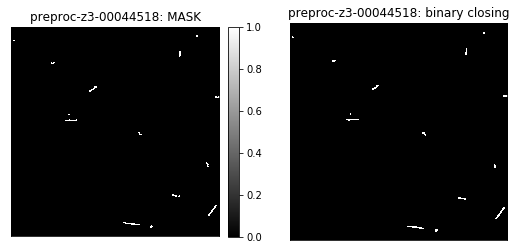

In [113]:
nrow, ncol = mask.shape
erow = np.linspace(0,nrow,9, dtype=int)
ecol = np.linspace(0,ncol,9, dtype=int)

for i, (r0, r1) in enumerate(zip(erow[:-1], erow[1:])):
    for j, (c0, c1) in enumerate(zip(ecol[:-1], ecol[1:])):
        output = 'preproc-z3-00044518_{:02d}_{:02d}.pdf'.format(i,j)
        submask = mask[r0:r1, c0:c1]
        subbcmask = bcmask[r0:r1, c0:c1]
        
        fig, axes = plt.subplots(1,2, figsize=(9,4))

        ax = axes[0]
        im = ax.imshow(submask, cmap='gray', origin='lower', interpolation='nearest')
        cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: MASK')

        ax = axes[1]
        im = ax.imshow(subbcmask, cmap='gray', origin='lower', interpolation='nearest')
        # cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set(xticks=[], yticks=[], title='preproc-z3-00044518: binary closing');
        
        fig.savefig(output)

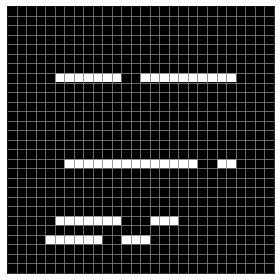

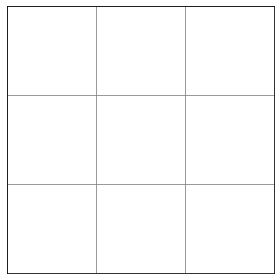

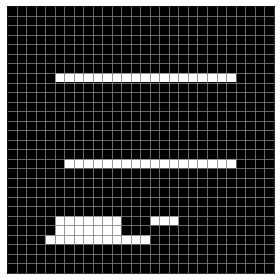

In [361]:
def plot_binary(img):
    nrow, ncol = img.shape
    
    fig, ax = plt.subplots(1,1, figsize=(4,4), tight_layout=True)
    ax.imshow(img, cmap='gray', origin='lower', interpolation='nearest', vmin=0, vmax=1)
    ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(nrow+1))
    ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(ncol+1))
    ax.set(xticklabels=[], yticklabels=[])
    ax.grid(color='gray')
    ax.tick_params(axis='both', length=0)
    
    return fig
    
dummy = np.zeros((28, 28))
dummy[3:4,4:10] = 1
dummy[3:4,12:15] = 1
dummy[5:6,5:12] = 1
dummy[5:6,15:18] = 1
dummy[11:12,6:20] = 1
dummy[11:12,22:24] = 1
dummy[20:21,5:12] = 1
dummy[20:21,14:24] = 1

fig = plot_binary(dummy)
fig.savefig('binary_img.pdf')

n1 = np.zeros((3,3))
# n1[1:2,:] = 1
# n1 = np.diag((1,1,1))[::-1]
n1 = np.ones((3,3))
fig = plot_binary(n1)
fig.savefig('binary_se.pdf')

bc = binary_closing(dummy, selem=n1)
fig = plot_binary(bc)
fig.savefig('binary_bc.pdf')

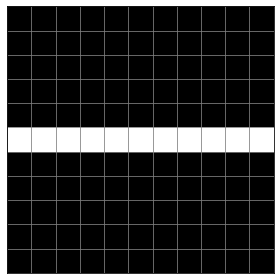

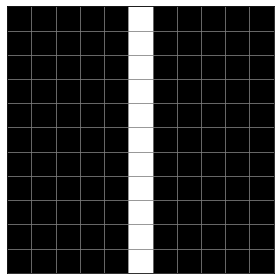

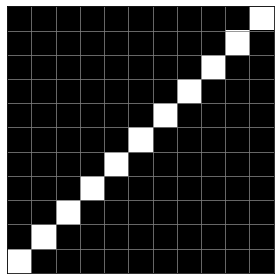

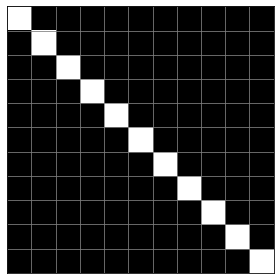

In [362]:
N = 11

n1 = np.zeros((N,N))
n1[N//2:N//2+1,:] = 1
fig = plot_binary(n1)
fig.savefig('se_n1.pdf')

n2 = n1.T
fig = plot_binary(n2)
fig.savefig('se_n2.pdf')

n3 = np.diag(np.diag(np.ones((N,N))))
fig = plot_binary(n3)
fig.savefig('se_n3.pdf')

n4 = n3[::-1]
fig = plot_binary(n4)
fig.savefig('se_n4.pdf')

In [352]:
bc = binary_closing(mask, selem=n1)
bc = bc | binary_closing(mask, selem=n2)
bc = bc | binary_closing(mask, selem=n3)
bc = bc | binary_closing(mask, selem=n4)

In [353]:
plot_chunks(img, mask, prefix='preproc-z3-00044518')
plot_chunks(img, mask, bc, prefix='preproc-z3-00044518-bc', title='binary closing')
# plot_chunks(img, mask, bc, prefix='preproc-z3-00044518', title='binary closing')

# dpi = 256
# fig = plt.figure(figsize=(bc.shape[1]/dpi, bc.shape[0]/dpi), dpi=dpi)
# ax = plt.Axes(fig, [0,0,1,1])
# ax.set_axis_off()
# fig.add_axes(ax)

# ax.imshow(bc, cmap='gray', vmin=0, vmax=1, origin='lower')
# fig.canvas.draw()
# fig.savefig('bcmask.pdf')

In [384]:
lines = probabilistic_hough_line(mask, threshold=10, line_length=8, line_gap=12, seed=1)

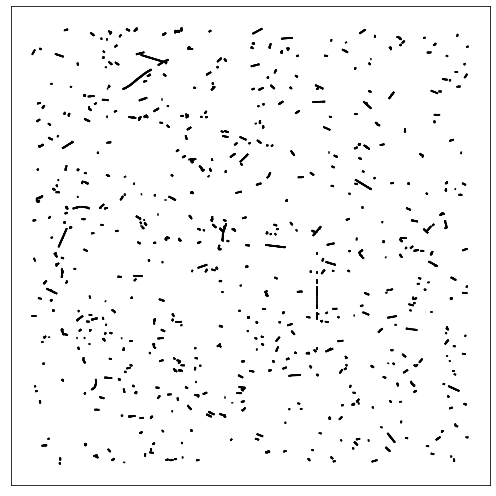

In [374]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
for line in lines:
    (x0,y0), (x1,y1) = line
    ax.plot([x0,x1], [y0,y1], 'k-')
ax.set(xticks=[], yticks=[])
fig.tight_layout()

In [375]:
fig.savefig('mask_hough.pdf')

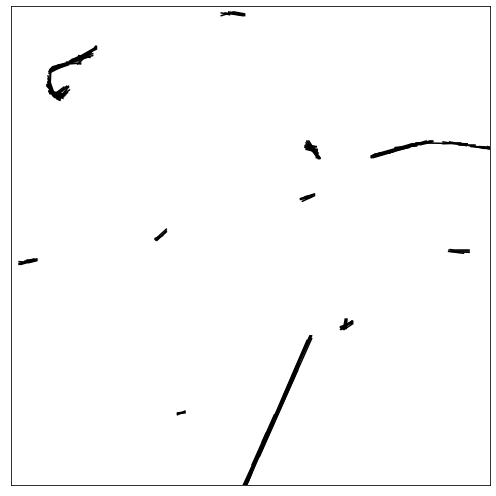

In [386]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
for line in lines:
    (x0,y0), (x1,y1) = line
    ax.plot([x0,x1], [y0,y1], 'k-')
ax.set(xticks=[], yticks=[],
       xlim=(0,514), ylim=(2064,2580))
fig.tight_layout()
fig.savefig('mask_hough_zoom.pdf')